# Import Modules

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import typing as tp
import time
import random
import math
from collections import deque
from dataclasses import dataclass

import torch
from torch import nn, Tensor

SEED = 563575
random.seed(SEED)
np.random.seed(SEED+1)
torch.manual_seed(SEED+2)
torch.use_deterministic_algorithms(mode=True, warn_only=False)

# Ops

In [2]:
def plot_environment(env:gym.Env, figsize:tuple[int, int]=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames:list, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    animation = anim.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    return animation

def show_one_episode(action_sampler:tp.Callable, n_max_steps=500, repeat=False):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    obs, info = env.reset()
    with torch.no_grad():
        for step in range(n_max_steps):
            frames.append(env.render())
            action = action_sampler(obs).cpu().item()
            obs, reward, done, truncated, info = env.step(action)
            if done or truncated:
                print("done at step", step+1)
                break
    env.close()
    return plot_animation(frames, repeat=repeat)

In [3]:
class CosineDecayWithWarmup:
    def __init__(
        self,
        warmup_steps:int,
        max_learning_rate:float,
        decay_steps:int,
        min_learning_rate:float
    ):
        self.warmup_steps = warmup_steps
        self.max_learning_rate = max_learning_rate
        self.decay_steps = decay_steps
        self.min_learning_rate = min_learning_rate

    def __call__(self, step):
        # linear warmup for warmup_steps steps
        if step < self.warmup_steps:
            return self.max_learning_rate * step / self.warmup_steps
        # if it > decay_steps, return min learning rate
        if step > self.decay_steps:
            return self.min_learning_rate
        # in between, use cosine decay down to min learning rate
        decay_ratio = (step - self.warmup_steps) / (self.decay_steps - self.warmup_steps)
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
        return self.min_learning_rate + coeff * (self.max_learning_rate - self.min_learning_rate)

In [4]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset(seed=1)
obs, obs.shape, info

(array([ 0.00118216,  0.04504637, -0.03558404,  0.04486495], dtype=float32),
 (4,),
 {})

# Cartpole Environment
* GOAL: Keep the pole upright for as long as possible
```python
Actions:
    left: 0
    right: 1

Observation Space: (4,)
```
![image.png](images/carpole_info.png)
* The cart x-position (index 0) can be take values between (-4.8, 4.8), but the episode terminates if the cart leaves the (-2.4, 2.4) range.
* The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°)

## Rewards
* Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted

## Episode End
* The episode ends if any one of the following occurs:
    * Termination: Pole Angle is greater than ±12°
    * Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    * Truncation: Episode length is greater than 500

# Actor-Critic method using State Values

In [5]:
@dataclass
class config:
    num_episodes:int = 600
    num_over_to_average_grads:int = 10
    max_steps_per_episode:int = 501
    
    gamma:float = 0.99
    
    actor_lr:float = 0.01
    critic_lr:float = 0.01
    
    weight_decay:float = 0.0 # if using prelu activation, weight decay for that param is not good
    batch_size:int = 64
    constlr_steps:int = int(num_episodes*0.4375)

    device:torch.device = torch.device("cuda" if False else "cpu") # cpu good for very very small models
    dtype:torch.dtype = torch.float32 if "cpu" in device.type else torch.float16

    autocast:torch.autocast = torch.autocast(
        device_type=device.type, dtype=dtype, enabled="cuda" in device.type
    )
    logging_interval:int = 1

    generator:torch.Generator = torch.Generator(device=device).manual_seed(SEED+343434)

In [6]:
class Policy(nn.Module):
    def __init__(self, num_inputs:int, num_hidden:int, num_outputs:int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.ELU(), # nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ELU(), # nn.ReLU(),
            nn.Linear(num_hidden, num_outputs),
            nn.Sigmoid() if num_outputs == 1 else nn.Softmax(dim=-1)
        )

    def forward(self, x:Tensor): # (B, num_inputs=4)
        return self.model(x)     # (B, num_outputs=2)

In [7]:
class Value(nn.Module):
    def __init__(self, num_inputs:int, num_hidden:int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.ELU(), # nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ELU(), # nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x:Tensor): # (B, num_inputs=4)
        return self.model(x)     # (B, 1)

## Algorithm Structure
* Make Actor critic models
* Make Training Loop
  * Loop over episodes
    * Loop over steps (till done)
      * Sample actions from policy, Observe next state and reward
      * Input state to Value/Critic Model to get the val
      * Calculate TD-Error
      * Optimize both Actor and Critic model

In [8]:
actor = Policy(
    num_inputs=env.observation_space.shape[0],     # 4
    num_hidden=env.observation_space.shape[0]*2,   # 8
    num_outputs=1 if env.action_space.n == 2 else env.action_space.n # (left, right)
); actor.compile()
actor_opt = torch.optim.NAdam(
    actor.parameters(),
    lr=config.actor_lr,
    weight_decay=config.weight_decay,
    maximize=True
)

critic = Value(
    num_inputs=env.observation_space.shape[0],  # 4
    num_hidden=env.observation_space.shape[0]*8 # 32
); critic.compile()
critic_opt = torch.optim.NAdam(
    critic.parameters(),
    lr=config.critic_lr,
    weight_decay=config.weight_decay,
    maximize=False
)

get_lr = CosineDecayWithWarmup(
    warmup_steps=1,
    max_learning_rate=config.actor_lr,
    decay_steps=config.num_episodes,
    min_learning_rate=config.actor_lr*0.1
)
print("Number of parameters in\n\tActor: {}\n\tCritic: {}".format(
    sum(p.numel() for p in actor.parameters()), 
    sum(p.numel() for p in critic.parameters())
    )
)

Number of parameters in
	Actor: 121
	Critic: 1249


![image](images/actor_critic.png)

In [9]:
def sample_actions_from_actor(state:Tensor, B:int=1): # sample actions from actor given state
    left_proba = actor(state) # (B, 1)
    action:Tensor = torch.rand((B, 1), device=config.device) > left_proba # If `left_proba` is high, then `action` will most likely be `False` or 0, which means left
    target = (~action).float() # 1 if action==0 (left) ; 0 elif action==1 (right)
    actor_loss = (torch.log(left_proba).mul(target) + torch.log(1-left_proba).mul(1.0 - target)).mean() # GRADIENT ASCENT so no -ve sign
    actor_loss.backward()
    actor_grads = [p.grad for p in actor.parameters()]; actor.zero_grad()
    return action.float(), actor_grads # 0 for left, 1 for right

In [10]:
def play():
    actor.zero_grad(); critic.zero_grad()
    episode_lens = []
    for episode in range(1, config.num_episodes+1):
        t0 = time.time()
        
        lr = get_lr(episode)
        actor_lr = lr     # config.actor_lr
        critic_lr = lr    # config.critic_lr
        actor_avg_over_grads:list[list[Tensor]] = []  # list[list[Tensor]] # (num_over_to_average_grads*max_steps_per_episode, num_params)
        critic_avg_over_grads:list[list[Tensor]] = [] # list[list[Tensor]] # (num_over_to_average_grads*max_steps_per_episode, num_params)

        for _ in range(config.num_over_to_average_grads):
            state, info = env.reset(); state = torch.as_tensor(state, device=config.device).unsqueeze(0)

            for time_step in range(0, config.max_steps_per_episode):
                action, actor_grads = sample_actions_from_actor(state)
                
                bef_state_value = critic(state)
                state, reward, done, truncated, _ = env.step(int(action.item())); state = torch.as_tensor(state, device=config.device).unsqueeze(0)
                aft_state_value:Tensor = torch.tensor(0.0, device=config.device).view(1, 1) if done else critic(state)
                td:Tensor = (reward + config.gamma*aft_state_value - bef_state_value).squeeze() # (,)

                critic_loss = td.square().mean(); critic_loss.backward() # MSE Loss
                critic_grads = [p.grad for p in critic.parameters()]; critic.zero_grad()
                actor_grads = [actor_grad.mul(td).mul(config.gamma**time_step) for actor_grad in actor_grads]
                actor_avg_over_grads.append(actor_grads)
                critic_avg_over_grads.append(critic_grads)

                if done or truncated:
                    break
        
        random.shuffle(actor_avg_over_grads); random.shuffle(critic_avg_over_grads)
        for i in range(config.num_over_to_average_grads*config.max_steps_per_episode):
            start_idx, end_idx = i*config.num_over_to_average_grads, (i+1)*config.num_over_to_average_grads
            for param, grads in zip(actor.parameters(), zip(*actor_avg_over_grads[start_idx:end_idx])):
                param.grad = torch.stack(grads).mean(dim=0)
            for param, grads in zip(critic.parameters(), zip(*critic_avg_over_grads[start_idx:end_idx])):
                param.grad = torch.stack(grads).mean(dim=0)
            actor_opt.step(); actor.zero_grad()
            critic_opt.step(); critic.zero_grad()

        t1 = time.time(); dt = t1 - t0
        print(f"| Step: {episode:<4}/ {config.num_episodes:<4} || Episode Length {time_step+1:<6.2f} || actor_lr: {actor_lr:<12e} | critic_lr: {critic_lr:<12e} || dt: {dt:<5.2f}s |")
        episode_lens.append(time_step+1)
    return episode_lens

episode_lens = play()

| Step: 1   / 600  || Episode Length 17.00  || actor_lr: 1.000000e-02 | critic_lr: 1.000000e-02 || dt: 6.68 s |
| Step: 2   / 600  || Episode Length 10.00  || actor_lr: 9.999938e-03 | critic_lr: 9.999938e-03 || dt: 0.33 s |
| Step: 3   / 600  || Episode Length 13.00  || actor_lr: 9.999752e-03 | critic_lr: 9.999752e-03 || dt: 0.33 s |
| Step: 4   / 600  || Episode Length 18.00  || actor_lr: 9.999443e-03 | critic_lr: 9.999443e-03 || dt: 0.32 s |
| Step: 5   / 600  || Episode Length 16.00  || actor_lr: 9.999010e-03 | critic_lr: 9.999010e-03 || dt: 0.29 s |
| Step: 6   / 600  || Episode Length 16.00  || actor_lr: 9.998453e-03 | critic_lr: 9.998453e-03 || dt: 0.29 s |
| Step: 7   / 600  || Episode Length 20.00  || actor_lr: 9.997772e-03 | critic_lr: 9.997772e-03 || dt: 0.27 s |
| Step: 8   / 600  || Episode Length 44.00  || actor_lr: 9.996968e-03 | critic_lr: 9.996968e-03 || dt: 0.31 s |
| Step: 9   / 600  || Episode Length 34.00  || actor_lr: 9.996040e-03 | critic_lr: 9.996040e-03 || dt: 0

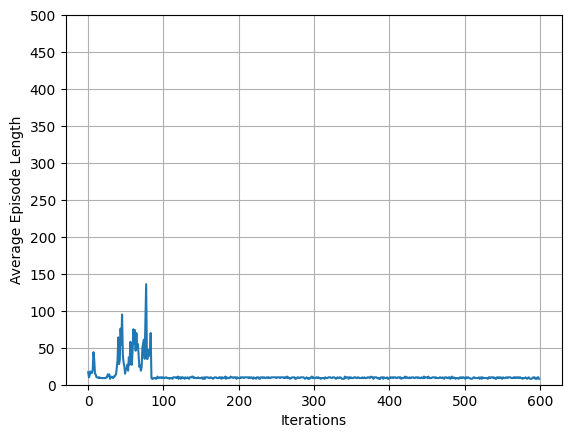

In [11]:
plt.plot(episode_lens)
plt.xlabel("Iterations")
plt.ylabel("Average Episode Length")
plt.yticks(range(0, 501, 50))
plt.grid(True)
plt.show()